# Relative Humidity prediction using linear regression (minimal)

Using the boston housing dataset: https://archive.ics.uci.edu/ml/datasets/Air+Quality

In [1]:
# Uncomment and run the commands below if imports fail
!conda install numpy pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - cpuonly
    - numpy
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    certifi-2020.4.5.2         |   py37hc8dfbb8_0         152 KB  conda-forge
    numpy-1.18.5               |   py37h8960a57_0         5.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.4 MB

The following packages will be UPDATED:

  ca-certificates                     2020.4.5.1-hecc5488_0 --> 2020.4.5.2-hecda079_0
  certifi                         2020.4.5.1-py37hc8dfbb8_0 --> 2020.4.5.2-py37hc8dfbb8_0
  numpy                               1.18.1-py37h8960a57_1 --> 1.18.5-py37h8960a57_0



certifi-2020.4.5.

In [2]:
# Imports
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from datetime import *
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

<IPython.core.display.Javascript object>

## Read file 

In [3]:
dataframe = pd.read_csv('../input/airquality-uci/AirQualityUCI.csv', delimiter =';', decimal= ',')
# here you have to use delimiter ';' which will make your raw data into tabular form with colums and rows
# decimal = ',' makes your column values seperated with dot rather than comma
dataframe.head()
# , parse_dates = [['Date', 'Time']]

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


# **Check Rows and Columns**

In [4]:
dataframe.shape

(9471, 17)

# Remove Columns with missing values

To drop rows or cos in csv, we use dropna()
axis = 1 means columns 
how = 'all' means if all column values are null, we will drop
inplace = 'True' means that this drop() will affect the origianl dataframe.

In [5]:
drop_dataframe = dataframe.dropna(axis = 1, how = 'all', inplace = True)

axis = 0 means index

In [6]:
drop_dataframe = dataframe.dropna(axis = 0, how = 'all')

In [7]:
drop_dataframe.tail()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9352,04/04/2005,10.00.00,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,04/04/2005,11.00.00,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005,12.00.00,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005,13.00.00,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139
9356,04/04/2005,14.00.00,2.2,1071.0,-200.0,11.9,1047.0,265.0,654.0,168.0,1129.0,816.0,28.5,13.1,0.5028


In [8]:
drop_dataframe.isna() # check if there's null 
# return False if no null

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9353,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9354,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9355,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


# Rename columns

In [9]:
drop_dataframe = drop_dataframe.rename(columns={'T': 'Temperature(\u2103)',
                                                'RH': 'Relative Humidity(%)',
                                                'AH': 'Absolute Humidity'})
drop_dataframe.head()
# For degree Celsius symbol, you can use the followings. Both work. 
# 'Temperature \N{DEGREE SIGN}C'
# 'Temperature(\u2103)'

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),Temperature(℃),Relative Humidity(%),Absolute Humidity
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


# Extract Date and Time

In [10]:
# however our date is in string format 
# extract date, month and year from date 
drop_dataframe['Day'] = pd.DatetimeIndex(drop_dataframe['Date']).day
drop_dataframe['month'] = pd.DatetimeIndex(drop_dataframe['Date']).month
drop_dataframe['year'] = pd.DatetimeIndex(drop_dataframe['Date']).year
drop_dataframe.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),Temperature(℃),Relative Humidity(%),Absolute Humidity,Day,month,year
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,3,10,2004
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,3,10,2004
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,3,10,2004
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,3,10,2004
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,3,10,2004


In [11]:
# Time is in string format in the given data.
# So we cannot usse datetime.hour to select it. 
# We will extract hour by the followings. 
drop_dataframe['Hour']=drop_dataframe['Time'].apply(lambda x: str(x)[0:2])
# what we want is float type and so convert string to float or int
drop_dataframe['Hour']= drop_dataframe['Hour'].apply(lambda x: float(x))
drop_dataframe.dtypes

Date                     object
Time                     object
CO(GT)                  float64
PT08.S1(CO)             float64
NMHC(GT)                float64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
Temperature(℃)          float64
Relative Humidity(%)    float64
Absolute Humidity       float64
Day                       int64
month                     int64
year                      int64
Hour                    float64
dtype: object

In [12]:
# remove date and time columns
df = drop_dataframe.drop(['Date', 'Time'], axis = 1)
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),Temperature(℃),Relative Humidity(%),Absolute Humidity,Day,month,year,Hour
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,3,10,2004,18.0
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,3,10,2004,19.0
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,3,10,2004,20.0
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,3,10,2004,21.0
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,3,10,2004,22.0


In [13]:
df.shape

(9357, 17)

In [14]:
import os 
os.chdir(r'/kaggle/working')
df.to_csv(r'df.csv')

# Select inputs and target

In [96]:
# To convert into Tensor, select columns in list form. If it is not numpy, you will see an error. 
input_cols = list(df.drop(['Relative Humidity(%)'], axis = 1)) 
#target_cols = list(df.columns)[11]
target_cols = list(df.drop(input_cols, axis = 1))
print('input_cols:', input_cols, '\n')
print('target_cols: ', target_cols)

input_cols: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'Temperature(℃)', 'Absolute Humidity', 'Day', 'month', 'year', 'Hour'] 

target_cols:  ['Relative Humidity(%)']


In [97]:
# convert to numpy
input_arrays = drop_dataframe[input_cols].to_numpy()
target_arrays = drop_dataframe[target_cols].to_numpy()
input_arrays.shape, target_arrays.shape
#target_arrays

((9357, 16), (9357, 1))

In [40]:
# convert input and targets into Pytorch Tensor, make sure data type is torch.float32
inputs = torch.from_numpy(np.array(input_arrays, dtype = 'float32'))
targets = torch.from_numpy(np.array(target_arrays, dtype = 'float32'))

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a TensorDataset.

# Prepare DataSet

In [41]:
dataset = TensorDataset(inputs, targets)

To determine the fraction of data that will be used for creating the validation set, we will use 0.2. It means that you use 80% for training, 20 % for validation from the given data. Then use random_split to create training & validation datasets. 

In [42]:
val_percent = 0.2 
num_rows = df.shape[0]
num_cols = df.shape[1]
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [val_size, train_size])

We will define batch size which is good for memory. If you train all data at the same time, your training will take a huge time.

In [43]:
batch_size = 64

In [44]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
# need to shuffle the train_ds for better result
val_loader = DataLoader(val_ds, batch_size)
# validation dataset does not to be shuffled because it is just for fit and evaluation

Check if it's working fine.

In [45]:
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),Temperature(℃),Relative Humidity(%),Absolute Humidity,Day,month,year,Hour
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,3,10,2004,18.0
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,3,10,2004,19.0
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,3,10,2004,20.0
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,3,10,2004,21.0
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,3,10,2004,22.0


In [46]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

# you won't see the same number in the same place as shown in above table because you shuffled the data 

inputs: tensor([[ 1.1000e+00,  9.1900e+02, -2.0000e+02,  ...,  1.1000e+01,
          2.0040e+03,  1.0000e+00],
        [ 9.0000e-01,  9.2000e+02, -2.0000e+02,  ...,  1.0000e+01,
          2.0040e+03,  8.0000e+00],
        [ 1.5000e+00,  1.0190e+03, -2.0000e+02,  ...,  7.0000e+00,
          2.0040e+03,  1.2000e+01],
        ...,
        [ 1.4000e+00,  1.0700e+03, -2.0000e+02,  ...,  8.0000e+00,
          2.0040e+03,  1.2000e+01],
        [ 2.6000e+00, -2.0000e+02,  2.6200e+02,  ...,  9.0000e+00,
          2.0040e+03,  1.1000e+01],
        [-2.0000e+02,  9.4100e+02, -2.0000e+02,  ...,  1.0000e+01,
          2.0040e+03,  4.0000e+00]])
targets: tensor([[  39.5000],
        [  66.7000],
        [  17.2000],
        [  41.0000],
        [  41.4000],
        [-200.0000],
        [-200.0000],
        [  68.3000],
        [  50.4000],
        [  47.3000],
        [  46.8000],
        [  50.1000],
        [  37.6000],
        [  18.3000],
        [  27.0000],
        [  40.1000],
        [  63.3

In [47]:
target_arrays

array([[48.9],
       [47.7],
       [54. ],
       ...,
       [18.3],
       [13.5],
       [13.1]])

## Create a linear Regression Model

In [48]:
input_size = len(input_cols)
output_size = len(target_cols)

In [59]:
class AQModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size) # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out,targets)                      # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out,targets)                          # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))
            
model = AQModel()

## Training

In [60]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [61]:
result = evaluate(model, val_loader) # Before using model
print(result)

{'val_loss': 452.1524353027344}


In [85]:
model = AQModel()
epochs = 10000
lr = 1e-8
history = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 151.7095
Epoch [40], val_loss: 136.5500
Epoch [60], val_loss: 127.4793
Epoch [80], val_loss: 122.1163
Epoch [100], val_loss: 118.8751
Epoch [120], val_loss: 116.7115
Epoch [140], val_loss: 115.2012
Epoch [160], val_loss: 113.9992
Epoch [180], val_loss: 112.9420
Epoch [200], val_loss: 111.9667
Epoch [220], val_loss: 111.0467
Epoch [240], val_loss: 110.1555
Epoch [260], val_loss: 109.2838
Epoch [280], val_loss: 108.4165
Epoch [300], val_loss: 107.5654
Epoch [320], val_loss: 106.7293
Epoch [340], val_loss: 105.9013
Epoch [360], val_loss: 105.0763
Epoch [380], val_loss: 104.2632
Epoch [400], val_loss: 103.4571
Epoch [420], val_loss: 102.6613
Epoch [440], val_loss: 101.8687
Epoch [460], val_loss: 101.0882
Epoch [480], val_loss: 100.3057
Epoch [500], val_loss: 99.5311
Epoch [520], val_loss: 98.7617
Epoch [540], val_loss: 97.9950
Epoch [560], val_loss: 97.2339
Epoch [580], val_loss: 96.4803
Epoch [600], val_loss: 95.7357
Epoch [620], val_loss: 94.9952
Epoch [640], val_lo

Epoch [5160], val_loss: 33.4589
Epoch [5180], val_loss: 33.3838
Epoch [5200], val_loss: 33.3089
Epoch [5220], val_loss: 33.2336
Epoch [5240], val_loss: 33.1614
Epoch [5260], val_loss: 33.0905
Epoch [5280], val_loss: 33.0170
Epoch [5300], val_loss: 32.9438
Epoch [5320], val_loss: 32.8763
Epoch [5340], val_loss: 32.8063
Epoch [5360], val_loss: 32.7362
Epoch [5380], val_loss: 32.6694
Epoch [5400], val_loss: 32.6019
Epoch [5420], val_loss: 32.5341
Epoch [5440], val_loss: 32.4694
Epoch [5460], val_loss: 32.4049
Epoch [5480], val_loss: 32.3405
Epoch [5500], val_loss: 32.2771
Epoch [5520], val_loss: 32.2153
Epoch [5540], val_loss: 32.1529
Epoch [5560], val_loss: 32.0919
Epoch [5580], val_loss: 32.0322
Epoch [5600], val_loss: 31.9704
Epoch [5620], val_loss: 31.9095
Epoch [5640], val_loss: 31.8514
Epoch [5660], val_loss: 31.7912
Epoch [5680], val_loss: 31.7336
Epoch [5700], val_loss: 31.6767
Epoch [5720], val_loss: 31.6217
Epoch [5740], val_loss: 31.5641
Epoch [5760], val_loss: 31.5118
Epoch [5

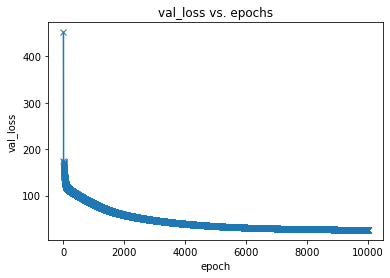

In [86]:
losses = [r['val_loss'] for r in [result] + history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

## Prediction

In [87]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [89]:
x, target = val_ds[10]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([ 6.1000e+00,  1.4580e+03, -2.0000e+02,  2.0400e+01,  1.3070e+03,
         7.0600e+02,  4.9700e+02,  1.6500e+02,  1.4830e+03,  2.1030e+03,
         6.1000e+00,  5.7190e-01,  2.4000e+01,  1.2000e+01,  2.0040e+03,
         9.0000e+00])
Target:  60.5
Prediction: 78.63116455078125


## Save and upload

In [90]:
torch.save(model.state_dict(), 'air-quality-linear-minimal.pth')

In [91]:
val_loss = [result] + history

In [92]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [ ]:
jovian.commit(project='air-quality-linear-minimal', environment=None, outputs=['air-quality-linear-minimal.pth'])
jovian.commit(project='air-quality-linear-minimal', environment=None, outputs=['air-quality-linear-minimal.pth']) # Kaggle commit fails sometimes, so try again..

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "khinthandarkyaw98/air-quality-linear-minimal" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/khinthandarkyaw98/air-quality-linear-minimal


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
